# Honey Price Prediction💸

### *Loading Dataset*

In [40]:
#Import necessary libraries
import pandas as pd
import numpy as np

In [41]:
#Load dataset
df = pd.read_csv('../data/Cleaned_data.csv')

In [42]:
df

,Color Score,Density,Water Content,pH,Electrical Conductivity,Fructose Level,Glucose Level,Pollen Analysis,Viscosity,Purity,Price
0,2.81,1.75,23.04,6.29,0.76,39.02,33.63,Blueberry,4844.50,0.68,645.24
1,9.47,1.82,17.50,7.20,0.71,38.15,34.41,Alfalfa,6689.02,0.89,385.85
2,4.61,1.84,23.72,7.31,0.80,27.47,34.36,Chestnut,6883.60,0.66,639.64
3,1.77,1.40,16.61,4.01,0.78,31.52,28.15,Blueberry,7167.56,1.00,946.46
4,6.11,1.25,19.63,4.82,0.90,29.65,42.52,Alfalfa,5125.44,1.00,432.62
...,...,...,...,...,...,...,...,...,...,...,...
247898,1.98,1.29,17.90,4.82,0.89,36.10,34.69,Rosemary,8261.63,1.00,754.98
247899,6.18,1.67,19.54,4.91,0.85,31.15,20.82,Acacia,6939.39,1.00,543.41
247900,7.78,1.49,15.78,5.69,0.73,44.60,44.07,Chestnut,4139.79,0.64,615.46
247901,5.78,1.74,14.96,6.81,0.83,47.19,37.79,Avocado,4417.74,0.97,949.32


### *Machine Learning Models*

In [43]:
#Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

In [44]:
#Preprocess the data
def preprocess_data(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(['Electrical Conductivity', 'Glucose Level', 'Fructose Level'], axis=1)
    
    #One hot Encoding
    one_hot_encoded_df = pd.get_dummies(df_copy['Pollen Analysis'], prefix='Pollen_Analysis')
    df_copy = pd.concat([df_copy, one_hot_encoded_df], axis=1)
    df_copy.drop('Pollen Analysis', axis=1, inplace=True)

    #Normalization
    scaler = MinMaxScaler()
    df_copy[df_copy.columns] = scaler.fit_transform(df_copy[df_copy.columns])
    return df_copy

In [14]:
#Cross-validation and evaluation
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = [math.sqrt(-score) for score in scores]
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    #Training on the training set
    model.fit(X_train, y_train)
    
    #Predicting on the test set
    y_pred = model.predict(X_test)
    
    #Computing test set metrics
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    return [name, np.mean(rmse_scores), np.mean(r2_scores), np.mean(mae_scores), test_rmse, test_r2, test_mae]

In [15]:
df_preprocessed = preprocess_data(df)
X = df_preprocessed.drop(['Price'], axis=1)
y = df_preprocessed['Price']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialize models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Lasso Regression', Lasso(alpha=1.0)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

results = []

for name, model in models:
    result = evaluate_model(model, name, X_train, y_train, X_test, y_test)
    results.append(result)

print('')
print('-'*30)
print('Evaluation complete!')

Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Lasso Regression...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating XGBoost...

------------------------------
Evaluation complete!


In [16]:
results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE'])
results_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE
0,Linear Regression,0.041640,0.977174,0.030911,0.041754,0.976964,0.030936
1,Ridge Regression,0.041640,0.977174,0.030912,0.041754,0.976964,0.030937
2,Lasso Regression,0.275619,-0.000075,0.225144,0.275107,-0.000049,0.224431
3,Random Forest,0.001236,0.999980,0.000597,0.001234,0.999980,0.000598
4,Gradient Boosting,0.030137,0.988042,0.026994,0.029656,0.988379,0.026474
5,XGBoost,0.001301,0.999978,0.000813,0.001314,0.999977,0.000830


In [22]:
#XGBoost model - Best performing model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [50]:
xgb_results = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred_xgb})
xgb_results['Actual Price'] = xgb_results['Actual Price'].round(2)
xgb_results['Predicted Price'] = xgb_results['Predicted Price'].round(2)
xgb_results.sample(n=5)

,Actual Price,Predicted Price
23344,0.43,0.44
100212,0.73,0.73
146426,0.58,0.59
167786,0.85,0.85
165175,0.29,0.29


In [ ]:
#Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

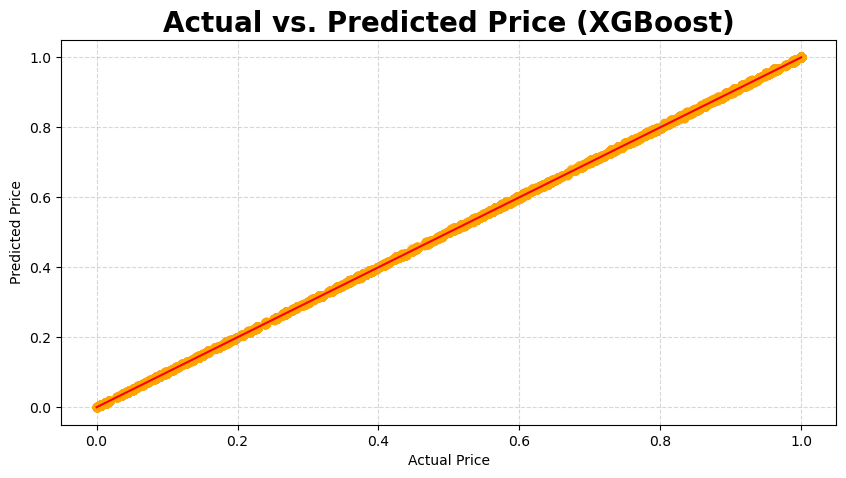

In [70]:
#Scatterplot - Actual vs. Predicted price
plt.figure(figsize=(10,5))

plt.scatter(y_test, y_pred_xgb, alpha=0.2, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.title('Actual vs. Predicted Price (XGBoost)', size=20, weight='bold', y=0.999)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.show()

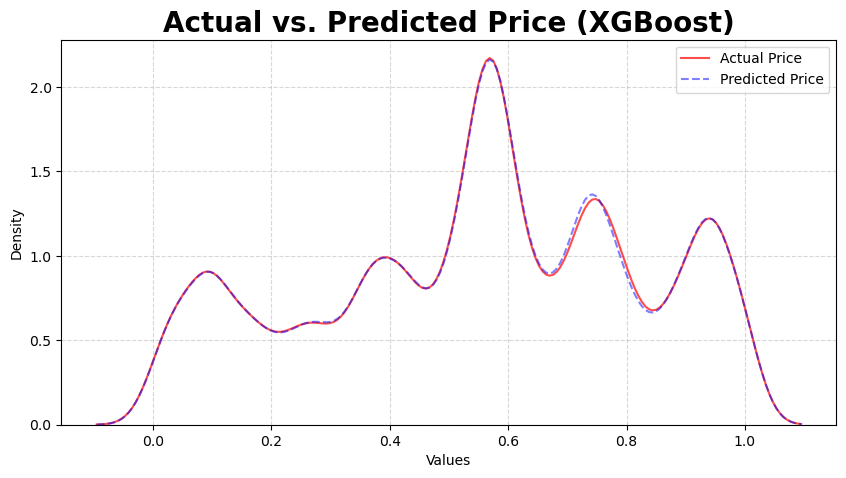

In [71]:
#KDEplot - Actual vs. Predicted price
plt.figure(figsize=(10, 5))

sns.kdeplot(xgb_results['Actual Price'], color='r', label='Actual Price', alpha=0.7)
sns.kdeplot(xgb_results['Predicted Price'], color='b', label='Predicted Price', alpha=0.5, linestyle='--')

plt.title('Actual vs. Predicted Price (XGBoost)', size=20, weight='bold', y=0.999)
plt.xlabel('Values')
plt.ylabel('Density')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.legend()
plt.show()